# Vehicle Routing Problem

In [1]:
class Node:
    
    def __init__(self, ID, x, y, demand):
        self.ID = ID # node identifier (depot ID = 0)
        self.x = x # Euclidean x-coordinate
        self.y = y # Euclidean y-coordinate
        self.demand = demand # demand (is 0 for depot and positive for others)
        self.inRoute = None # route to which node belongs
        self.isInterior = False # an interior node is not connected to depot
        self.dnEdge = None # edge (arc) that depot to this node
        self.ndEdge = None # edge (arc) from this node to depot

In [2]:
class Edge:
    
    def __init__(self, origin, end):
        self.origin = origin # origin node of the edge (arc)
        self.end = end # end node of the edge (arc)
        self.cost = 0.0 # edge cost
        self.savings = 0.0 # edge savings (Clarke & Wright)
        self.invEdge = None # inverse edge (arc)

In [3]:
class Route:
    
    def __init__(self):
        self.cost = 0.0 # cost of this route
        self.edges = [] # sorted edges in this route
        self.demand = 0.0 # total demand covered by this route
        
    def reverse(self): # e.g. 0 -> 2 -> 6 -> 0 becomes 0 -> 6 -> 2 -> 0
        size = len(self.edges)
        for i in range(size):
            edge = self.edges[i]
            invEdge = edge.invEdge
            self.edges.remove(edge)
            self.edges.insert(0, invEdge)

In [4]:
class Solution:
    
    last_ID = -1 # counts the number of solutions, starts with 0
    
    def __init__(self):
        Solution.last_ID += 1
        self.ID = Solution.last_ID
        self.routes = [] # routes in the solution
        self.cost = 0.0 # cost of this solution
        self.demand = 0.0 # total demand coverd by this solution

In [5]:
""" Perform the edge-selection & routing-merging iterative process """

def checkMergingConditions(iNode, jNode, iRoute, jRoute):
    # condition 1: iRoute and jRoute are not the same route object
    if iRoute == jRoute: return False
    # condition 2: both nodes are exterior nodes in their respective routes
    if iNode.isInterior == True or jNode.isInterior == True: return False
    # condition 3: demand after meging can be covered by a single vehicle
    if vehCap < iRoute.demand + jRoute.demand: return False
    # else, merging is feasible
    return True

def getDepotEdge(aRoute, aNode):
    ''' returns the edge in aRoute that contains aNode and the depot
        (it will be the first or the last one)'''
    origin = aRoute.edges[0].origin
    end = aRoute.edges[0].end
    if ((origin == aNode and end == depot) or
        (origin == depot and end == aNode)):
        return aRoute.edges[0]
    else: # return last edge in aRoute
        return aRoute.edges[-1]

In [6]:
""" Clarke & Wright savings heuristic for the VRP """

# from vrp_objects import Node, Edge, Route, Solution
import math
import operator
import time

In [7]:
""" Read instance data from txt file """

start = time.time()
vehCap = 100.0 # update vehicle capacity for each instance
instanceName = 'A-n80-k10' # name of the instance
# txt file with the VRP instance data (nodeID, x, y, demand)
fileName = 'data/' + instanceName + '_input_nodes.txt'

with open(fileName) as instance:
    i=0
    nodes = []
    for line in instance:
        #array data with node data: x, y, demand
        data = [float(x) for x in line.split()]
        aNode = Node(i, data[0], data[1], data[2])
        nodes.append(aNode)
        i += 1
        
depot = nodes[0] # node 0 is the depot
for node in nodes[1:]: # excludes de depot
    dnEdge = Edge (depot, node) # creates the (depot, node) edge (arc)
    ndEdge = Edge (node, depot)
    dnEdge.invEdge = ndEdge # sets the inverse edge (arc)
    ndEdge.invEdge = dnEdge
    # compute the Euclidean distance as cost
    dnEdge.cost = math.sqrt((node.x - depot.x)**2 + (node.y - depot.y)**2)
    ndEdge.cost = dnEdge.cost # assume symmetric costs
    # save in node a reference to the (depot, node) edge (arc)
    node.dnEdge = dnEdge
    node.ndEdge = ndEdge
    
savingsList = []
for i in range(1, len(nodes)-1): # excludes de depot
    iNode = nodes[i]
    for j in range(i + 1, len(nodes)):
        jNode = nodes[j]
        ijEdge = Edge(iNode, jNode) # creates the (i, j) edge
        jiEdge = Edge(jNode, iNode)
        ijEdge.invEdge = jiEdge # sets the inverse edge (arc)
        jiEdge.invEdge = ijEdge
        # compute the Euclidean distance as cost
        ijEdge.cost = math.sqrt((jNode.x - iNode.x)**2 + (jNode.y - iNode.y)**2)
        jiEdge.cost = ijEdge.cost # assume symmetric costs
        # compute savings as proposed by Clark & Wright
        ijEdge.savings = iNode.ndEdge.cost + jNode.dnEdge.cost - ijEdge.cost
        jiEdge.savings = ijEdge.savings
        # save one edge in the savings list
        savingsList.append(ijEdge)
        
# sort the list of edges from higher to lower savings
savingsList.sort(key = operator.attrgetter("savings"), reverse = True)


""" Construct the dummy solution """

sol = Solution()

for node in nodes[1:]: # excludes the depot
    dnEdge = node.dnEdge # get the (depot, node) edge
    ndEdge = node.ndEdge
    dndRoute = Route() # construct the route (depot, node, depot)
    dndRoute.edges.append(dnEdge)
    dndRoute.demand += node.demand
    dndRoute.cost += dnEdge.cost
    dndRoute.edges.append(ndEdge)
    dndRoute.cost += ndEdge.cost
    node.inRoute = dndRoute # save in node a reference to its current route
    node.isInterior = False # this node is currently exterior (connected to depot)
    sol.routes.append(dndRoute) # add this route to the solution
    sol.cost += dndRoute.cost
    sol.demand += dndRoute.demand
    
while len(savingsList) > 0: # list is not empty
    ijEdge = savingsList.pop(0) # select the next edge from the list
    # determine thje nodes i < j that define the edge
    iNode = ijEdge.origin
    jNode = ijEdge.end
    # determine the routes associated with each node
    iRoute = iNode.inRoute
    jRoute = jNode.inRoute
    # check if merge is possible
    isMergeFeasible = checkMergingConditions(iNode, jNode, iRoute, jRoute)
    # if all necessary conditions are satisfied, merge
    if isMergeFeasible == True:
        # iRoute will contain either edge (depot, i) or edge (i, depot)
        iEdge = getDepotEdge(iRoute, iNode) # iEdge is either (0,i) or (i,0)
        # remove iEdge from iRoute and update iRoute cost
        iRoute.edges.remove(iEdge)
        iRoute.cost -= iEdge.cost
        # if there are multple edges in iRoute, then i will be interior
        if len(iRoute.edges) > 1: iNode.isInterior = True
        # if new iRoute does not start at 0 it must be reversed
        if iRoute.edges[0].origin != depot: iRoute.reverse()
        # jRoute will contain either edge (depot, j) or edge (j, depot)
        jEdge = getDepotEdge(jRoute, jNode) # jEdge is either (0,j) or (j,0)
        # remove jEdge from jRoute and update jRoute cost
        jRoute.edges.remove(jEdge)
        jRoute.cost -= jEdge.cost
        # if there are multiple edges in jRoute, the j will b einterior
        if len(jRoute.edges) > 1: jNode.isInterior = True
        # if new jRoute starts at 0 it must be reversed
        if jRoute.edges[0].origin == depot: jRoute.reverse()
        # add ijEdge to iRoute
        iRoute.edges.append(ijEdge)
        iRoute.cost += ijEdge.cost
        iRoute.demand += jNode.demand
        jNode.inRoute = iRoute
        # add jRoute to new iRoute
        for edge in jRoute.edges:
            iRoute.edges.append(edge)
            iRoute.cost += edge.cost
            iRoute.demand += edge.end.demand
            edge.end.inRoute = iRoute
        # delete jRoute from emerging solution
        sol.cost -= ijEdge.savings
        sol.routes.remove(jRoute)
        

end = time.time()

print(end - start)

0.03323197364807129


In [8]:
print('Cost of C&W savings sol = ', "{:.{}f}".format(sol.cost, 2))
for route in sol.routes:
    s = str(0)
    for edge in route.edges:
        s = s + '-' + str(edge.end.ID)
    print('Route: ' + s + ' || cost = ' + "{:.{}f}".format(route.cost, 2))

Cost of C&W savings sol =  1860.94
Route: 0-1-63-10-7-21-0 || cost = 130.70
Route: 0-64-17-31-27-59-5-23-62-0 || cost = 188.89
Route: 0-24-6-30-78-8-37-2-34-71-0 || cost = 220.95
Route: 0-11-52-28-79-18-48-14-0 || cost = 193.22
Route: 0-13-74-39-60-29-44-12-0 || cost = 143.38
Route: 0-46-20-75-25-41-15-55-9-54-72-0 || cost = 248.96
Route: 0-33-47-56-69-65-35-26-19-57-61-16-43-68-0 || cost = 307.36
Route: 0-36-38-66-67-53-3-77-51-0 || cost = 145.84
Route: 0-40-42-73-49-0 || cost = 87.05
Route: 0-70-76-50-45-22-4-32-58-0 || cost = 194.59


In [9]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [10]:
# Colors list
colores = list(mcolors.TABLEAU_COLORS)

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


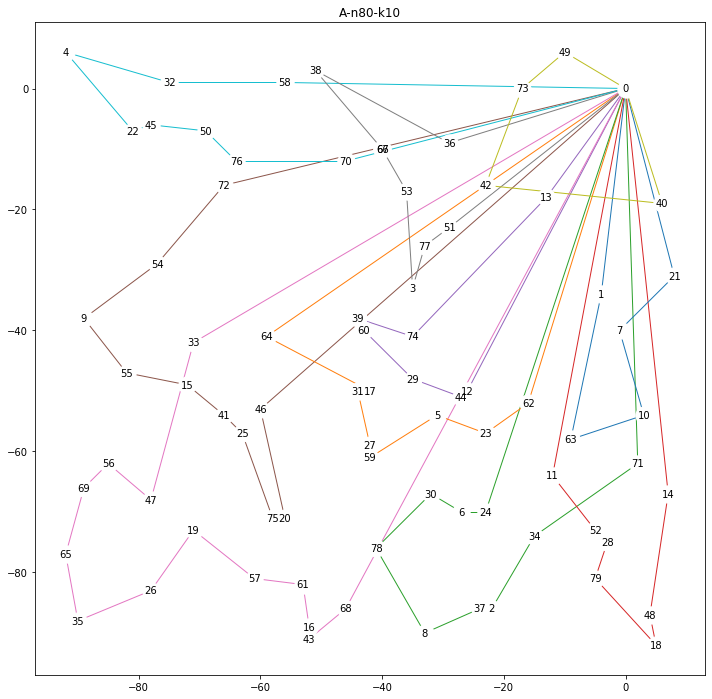

In [11]:
figure = plt.figure(figsize=(12,12))
G = nx.Graph()

i=0
for route in sol.routes:
    for edge in route.edges:
        G.add_edge(edge.origin.ID, edge.end.ID, color=colores[i%len(colores)])
        G.add_node(edge.end.ID, coord = (edge.end.x, edge.end.y), color=colores[i%len(colores)])
    i += 1    
        
coord = nx.get_node_attributes(G, 'coord')

col = nx.get_node_attributes(G, 'color')
nodecolor = [col[u] for u in col]
edges = G.edges()
edgecolor =  [G[u][v]['color'] for u,v in edges]

#nx.draw_networkx(G,coord, node_color=nodecolor, edge_color=edgecolor, font_color='white', font_size=10)
nx.draw_networkx(G,coord, node_color='white', edge_color=edgecolor, font_color='black', font_size=10)
limits = plt.axis('on')
ax = figure.gca()
ax.tick_params(left=True, bottom= True, labelleft=True, labelbottom=True)
plt.title(instanceName)
plt.show()

# Animation

In [12]:
# Reference: https://stackoverflow.com/questions/8744113/python-list-by-value-not-by-reference
# Other solution : b = [[a[x][y] for y in range(len(a[0]))] for x in range(len(a))]
# 
# In order to store the state after an iteration is required to copy the solution
# The solution is a list of routes which are a list of edges. 
from copy import deepcopy

In [13]:
""" Read instance data from txt file """

start = time.time()
vehCap = 100.0 # update vehicle capacity for each instance
instanceName = 'A-n80-k10' # name of the instance
# txt file with the VRP instance data (nodeID, x, y, demand)
fileName = 'data/' + instanceName + '_input_nodes.txt'

with open(fileName) as instance:
    i=0
    nodes = []
    for line in instance:
        #array data with node data: x, y, demand
        data = [float(x) for x in line.split()]
        aNode = Node(i, data[0], data[1], data[2])
        nodes.append(aNode)
        i += 1
        
depot = nodes[0] # node 0 is the depot
for node in nodes[1:]: # excludes de depot
    dnEdge = Edge (depot, node) # creates the (depot, node) edge (arc)
    ndEdge = Edge (node, depot)
    dnEdge.invEdge = ndEdge # sets the inverse edge (arc)
    ndEdge.invEdge = dnEdge
    # compute the Euclidean distance as cost
    dnEdge.cost = math.sqrt((node.x - depot.x)**2 + (node.y - depot.y)**2)
    ndEdge.cost = dnEdge.cost # assume symmetric costs
    # save in node a reference to the (depot, node) edge (arc)
    node.dnEdge = dnEdge
    node.ndEdge = ndEdge
    
savingsList = []
for i in range(1, len(nodes)-1): # excludes de depot
    iNode = nodes[i]
    for j in range(i + 1, len(nodes)):
        jNode = nodes[j]
        ijEdge = Edge(iNode, jNode) # creates the (i, j) edge
        jiEdge = Edge(jNode, iNode)
        ijEdge.invEdge = jiEdge # sets the inverse edge (arc)
        jiEdge.invEdge = ijEdge
        # compute the Euclidean distance as cost
        ijEdge.cost = math.sqrt((jNode.x - iNode.x)**2 + (jNode.y - iNode.y)**2)
        jiEdge.cost = ijEdge.cost # assume symmetric costs
        # compute savings as proposed by Clark & Wright
        ijEdge.savings = iNode.ndEdge.cost + jNode.dnEdge.cost - ijEdge.cost
        jiEdge.savings = ijEdge.savings
        # save one edge in the savings list
        savingsList.append(ijEdge)
        
# sort the list of edges from higher to lower savings
savingsList.sort(key = operator.attrgetter("savings"), reverse = True)


""" Construct the dummy solution """

tempSolutions = []
listCosts = []
listDemand = []

sol = Solution()

for node in nodes[1:]: # excludes the depot
    dnEdge = node.dnEdge # get the (depot, node) edge
    ndEdge = node.ndEdge
    dndRoute = Route() # construct the route (depot, node, depot)
    dndRoute.edges.append(dnEdge)
    dndRoute.demand += node.demand
    dndRoute.cost += dnEdge.cost
    dndRoute.edges.append(ndEdge)
    dndRoute.cost += ndEdge.cost
    node.inRoute = dndRoute # save in node a reference to its current route
    node.isInterior = False # this node is currently exterior (connected to depot)
    sol.routes.append(dndRoute) # add this route to the solution
    sol.cost += dndRoute.cost
    sol.demand += dndRoute.demand
    
tempRoutes = []
tempRoutes = deepcopy(sol.routes)
tempSolutions.append(tempRoutes)
listCosts.append(sol.cost)
listDemand.append(sol.demand)

    
while len(savingsList) > 0: # list is not empty
    ijEdge = savingsList.pop(0) # select the next edge from the list
    # determine thje nodes i < j that define the edge
    iNode = ijEdge.origin
    jNode = ijEdge.end
    # determine the routes associated with each node
    iRoute = iNode.inRoute
    jRoute = jNode.inRoute
    # check if merge is possible
    isMergeFeasible = checkMergingConditions(iNode, jNode, iRoute, jRoute)
    # if all necessary conditions are satisfied, merge
    if isMergeFeasible == True:
        # iRoute will contain either edge (depot, i) or edge (i, depot)
        iEdge = getDepotEdge(iRoute, iNode) # iEdge is either (0,i) or (i,0)
        # remove iEdge from iRoute and update iRoute cost
        iRoute.edges.remove(iEdge)
        iRoute.cost -= iEdge.cost
        # if there are multple edges in iRoute, then i will be interior
        if len(iRoute.edges) > 1: iNode.isInterior = True
        # if new iRoute does not start at 0 it must be reversed
        if iRoute.edges[0].origin != depot: iRoute.reverse()
        # jRoute will contain either edge (depot, j) or edge (j, depot)
        jEdge = getDepotEdge(jRoute, jNode) # jEdge is either (0,j) or (j,0)
        # remove jEdge from jRoute and update jRoute cost
        jRoute.edges.remove(jEdge)
        jRoute.cost -= jEdge.cost
        # if there are multiple edges in jRoute, the j will b einterior
        if len(jRoute.edges) > 1: jNode.isInterior = True
        # if new jRoute starts at 0 it must be reversed
        if jRoute.edges[0].origin == depot: jRoute.reverse()
        # add ijEdge to iRoute
        iRoute.edges.append(ijEdge)
        iRoute.cost += ijEdge.cost
        iRoute.demand += jNode.demand
        jNode.inRoute = iRoute
        # add jRoute to new iRoute
        for edge in jRoute.edges:
            iRoute.edges.append(edge)
            iRoute.cost += edge.cost
            iRoute.demand += edge.end.demand
            edge.end.inRoute = iRoute
        # delete jRoute from emerging solution
        sol.cost -= ijEdge.savings
        sol.routes.remove(jRoute)
        
        tempRoutes = []
        tempRoutes = deepcopy(sol.routes)
        tempSolutions.append(tempRoutes)
        listCosts.append(sol.cost)
        listDemand.append(sol.demand)
        
        
        

end = time.time()

print(end - start)

1.2742249965667725


In [14]:
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [22]:
def plot_best_routes(img_list):
    
    fig = plt.figure(figsize=(12,12))
    #creating a subplot 
    ax = fig.add_subplot(1,1,1)
    #plt.axis([-5,5,-5,5])
    xmin = -95
    xmax = 10
    ymin = -95
    ymax = 10
    
    def init():
        sol_routes = img_list[0]
        ax = fig.gca()
        ax.clear()
        ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))        
        
        #ax.scatter(sol.x, sol.y, color = 'r', label='Random Trial')
        #ax.scatter(sol.bestSol[0],sol.bestSol[1], color='b');
        #ax.scatter(sol.bestSol[-1][0], sol.bestSol[-1][1], color='b', label='Best solution')
        G = nx.Graph()

        j=0
        for route in sol_routes:
            for edge in route.edges:
                G.add_edge(edge.origin.ID, edge.end.ID, color=colores[edge.origin.ID%len(colores)])
                G.add_node(edge.end.ID, coord = (edge.end.x, edge.end.y), color=colores[edge.end.ID%len(colores)])
            j += 1    

        coord = nx.get_node_attributes(G, 'coord')

        col = nx.get_node_attributes(G, 'color')
        nodecolor = [col[u] for u in col]
        edges = G.edges()
        edgecolor =  [G[u][v]['color'] for u,v in edges]

        nx.draw_networkx(G,coord, node_color=nodecolor, edge_color=edgecolor, font_color='white', font_size=10)
        #nx.draw_networkx(G,coord, node_color='white', edge_color=edgecolor, font_color='black', font_size=10)
        limits = plt.axis('on')
        ax.tick_params(left=True, bottom= True, labelleft=True, labelbottom=True)
        plt.title(instanceName + " - Step: 1")
        
        #ax.set_title("Iteration: %d" % sol.i)
#        ax.legend(bbox_to_anchor=(0.05, 0.05), loc='lower left', borderaxespad=0.)
        
        return fig,
    
    def animate(i):
        sol_routes = img_list[i]
        ax = fig.gca()
        ax.clear()
        ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))  
        
        G = nx.Graph()
        G.clear()

        j=0
        for route in sol_routes:
            for edge in route.edges:
                # Trial to avoid changing colors
                if len(route.edges) > 2:
                    G.add_edge(edge.origin.ID, edge.end.ID, color=colores[j%len(colores)])
                    G.add_node(edge.end.ID, coord = (edge.end.x, edge.end.y), color=colores[j%len(colores)])
                else:
                    G.add_edge(edge.origin.ID, edge.end.ID, color=colores[edge.origin.ID%len(colores)])
                    G.add_node(edge.end.ID, coord = (edge.end.x, edge.end.y), color=colores[edge.end.ID%len(colores)])
                    
            j += 1    

        coord = nx.get_node_attributes(G, 'coord')

        col = nx.get_node_attributes(G, 'color')
        nodecolor = [col[u] for u in col]
        edges = G.edges()
        edgecolor =  [G[u][v]['color'] for u,v in edges]

        nx.draw_networkx(G,coord, node_color=nodecolor, edge_color=edgecolor, font_color='white', font_size=10)
        #nx.draw_networkx(G,coord, node_color='white', edge_color=edgecolor, font_color='black', font_size=10)
        limits = plt.axis('on')
        ax.tick_params(left=True, bottom= True, labelleft=True, labelbottom=True)
        plt.title(instanceName + " - Step: "+ str(i+1))        
        
        
#         ax.set_title("Iteration: %d" % sol.i)         
#         line = Line2D([x[0] for x in sol.bestSol[1:]], 
#                       [x[1] for x in sol.bestSol[1:]], color='g')
#         ax.add_line(line)
#        ax.legend(bbox_to_anchor=(0.05, 0.05), loc='lower left', borderaxespad=0.)
#         plt.show()
        return fig,
    
#     sol = img_list[0]
#     plt.scatter(sol.x, sol.y, color = 'r')
#     plt.scatter(sol.bestSol[0],sol.bestSol[1], color='b');
    
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(img_list), interval=500, blit=True,
                                   cache_frame_data=False)  
    
    #plt.close() # It appears a plot under the animation but if not commented it doesn't appears anything.
    return anim 



C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


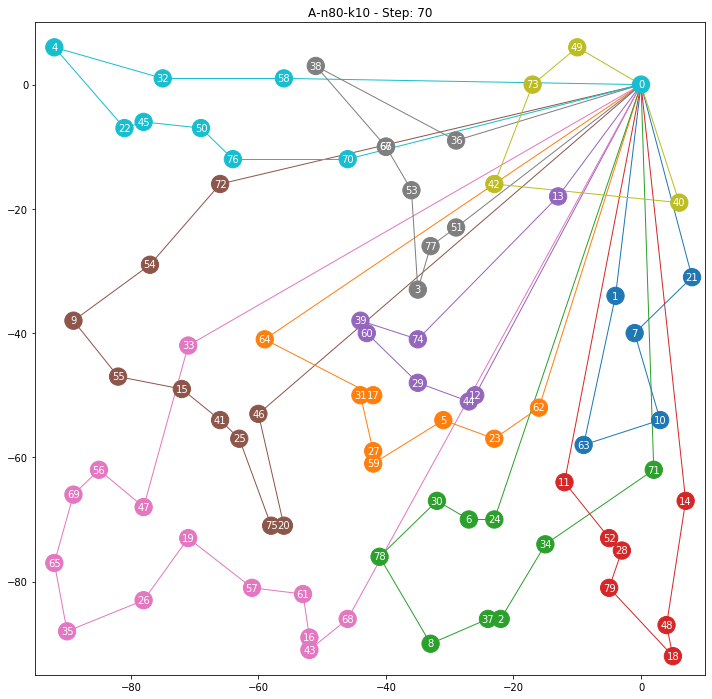

In [23]:
from IPython.display import HTML
HTML(plot_best_routes(tempSolutions).to_html5_video())
